In [2]:
# Import Statements
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

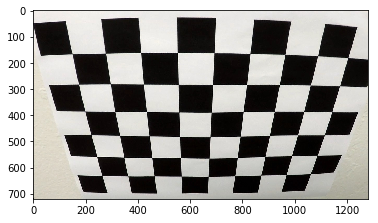

In [3]:
# Camera Calibration

# Chessboard 9x6

# Read in a calibration image
img = mpimg.imread("camera_cal/calibration2.jpg")
plt.imshow(img)

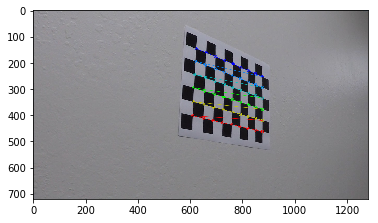

In [4]:
# Camera Calibration

# Read in and make a list of calibration images
images = glob.glob("camera_cal/calibration*.jpg")


# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane


# Prepare object points, like (0,0,0), (1, 0, 0), (2,0,0) ..., (8, 5, 0)
objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x , y coordinates

for fname in images:
    
    # read in each iage
    img = mpimg.imread(fname)

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)


    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

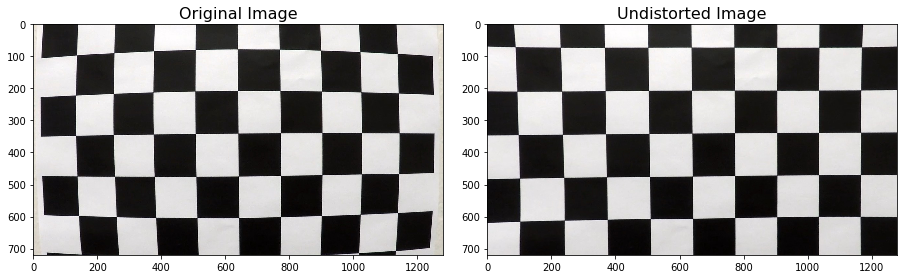

In [7]:
# Correcting for Distortion

# Read in a test image
img = mpimg.imread(images[0])

# Calibrate Camera
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Undistort IMage
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Show comparison between orignal and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(dst)
ax2.set_title("Undistorted Image", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

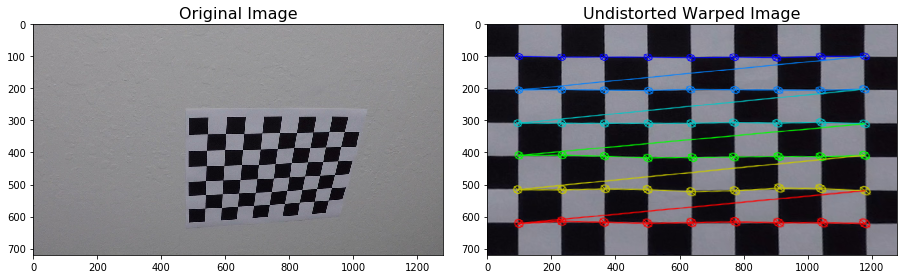

In [6]:
# Perspective Transform

def corners_unwarp(img, nx, ny, mtx, dist):
    
    # Undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    # Search for corners in the grayscale image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    if ret == True:
        
        # If corners are found, draw them
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        
        # Choose offst from image corners to plot detected corners
        offset = 100
        
        # Determine image size
        img_size = (gray.shape[1], gray.shape[0])
        
        # Determine image source points
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        
        # Determine image destination points
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                         [img_size[0]-offset, img_size[1]-offset], 
                         [offset, img_size[1]-offset]])
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        
        # warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    
    # Return the resulting image and matrix
    return warped, M


nx = 9
ny = 6

warped_image, M = corners_unwarp(img, nx, ny, mtx, dist)

# Show comparison between orignal and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(warped_image)
ax2.set_title("Undistorted Warped Image", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)


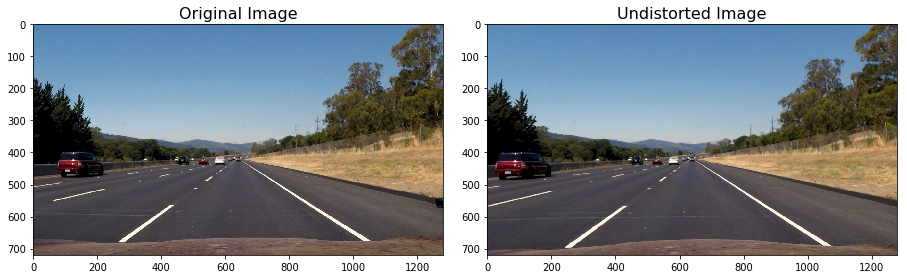

In [220]:


def undistort_image(image, mtx, dist):
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    return undist









image = mpimg.imread("test_images/straight_lines2.jpg")


# Undistort IMage
undist_image = undistort_image(image, mtx, dist)

# Show comparison between orignal and undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(undist_image)
ax2.set_title("Undistorted Image", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)



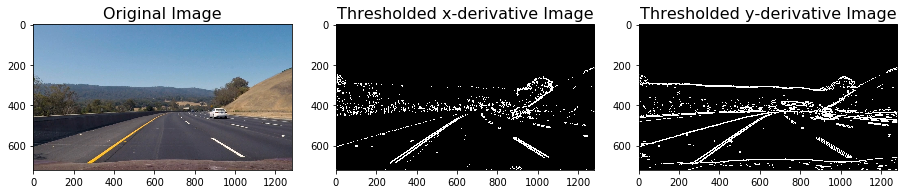

In [316]:
# Gradient Threshold

image = mpimg.imread("test_images/test3.jpg")




def abs_sobel_thresh(img, orient="x", sobel_kernel=15, thresh=(0,255)):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply cv2.Sobel()
    # Take the absolute value of the output from cv2.Sobel()
    
    if orient == "x":
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    
    if orient == "y":
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create binary_output
    # Apply lower and upper thresholds
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    
    return binary_output


gradx = abs_sobel_thresh(image, orient="x", sobel_kernel=15, thresh=(20, 150))
grady = abs_sobel_thresh(image, orient="y", sobel_kernel=15, thresh=(20, 150))

# Show comparison between orignal and thresholded x-derivative
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(gradx, cmap="gray")
ax2.set_title("Thresholded x-derivative Image", fontsize=16)
ax3.imshow(grady, cmap="gray")
ax3.set_title("Thresholded y-derivative Image", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)



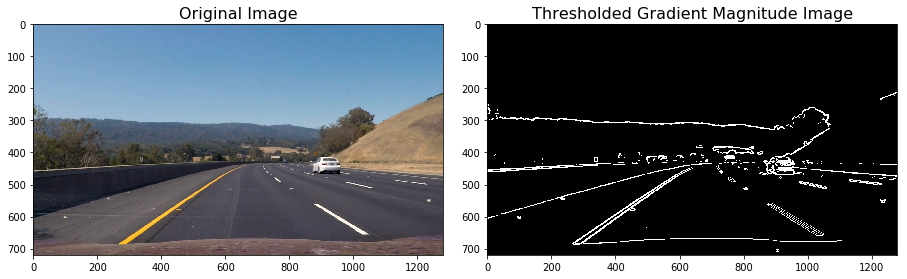

In [317]:
# Magnitude of the Gradient


def mag_thresh(img, sobel_kernel=15, mag_thresh=(30, 100)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0-255) and convert to type np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Create a binary mask where mag thresholds are met
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output



mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(50, 150))


# Show comparison between orignal and magnitude derivative
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(mag_binary, cmap="gray")
ax2.set_title("Thresholded Gradient Magnitude Image", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)




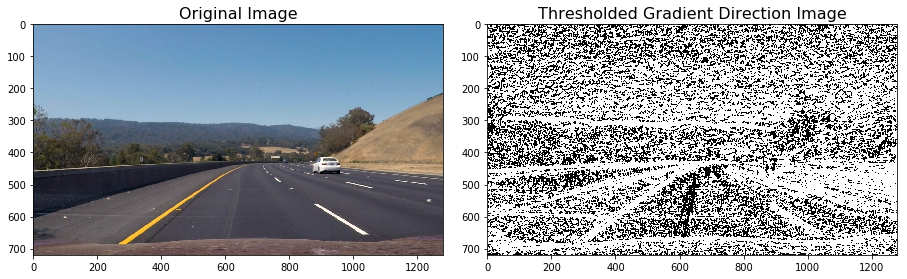

In [318]:
# Direction of Gradient


def dir_threshold(img, sobel_kernel=15, thresh=(0, np.pi/2)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2() to calculate the direction of the gradient
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output
    
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(np.pi/4, np.pi/2))
    
# Show comparison between orignal and direction derivative
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(dir_binary, cmap="gray")
ax2.set_title("Thresholded Gradient Direction Image", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)



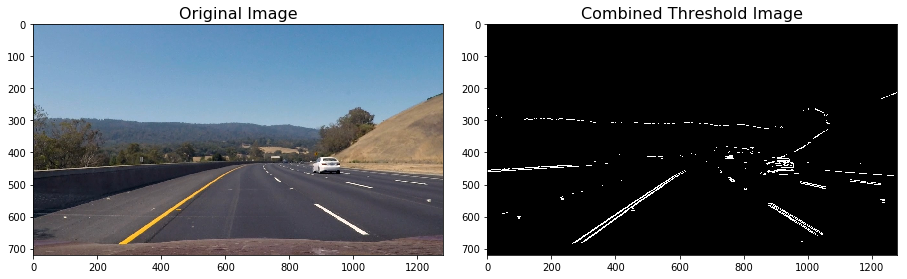

In [319]:

def combined_threshold(img, kernel_size=3):
    
    # Apply each thresholding function
    
    gradx = abs_sobel_thresh(img, orient="x", sobel_kernel=kernel_size, thresh=(50, 150))
    grady = abs_sobel_thresh(img, orient="y", sobel_kernel=kernel_size, thresh=(50, 150))
    mag_binary = mag_thresh(img, sobel_kernel=kernel_size, mag_thresh=(80, 200))
    dir_binary = dir_threshold(img, sobel_kernel=kernel_size, thresh=(np.pi/4, np.pi/2))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx ==1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined


# higher kernel size makes image less noisey, works better
combined_binary = combined_threshold(image, kernel_size=15)

# Show comparison between orignal and direction derivative
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(combined_binary, cmap="gray")
ax2.set_title("Combined Threshold Image", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)

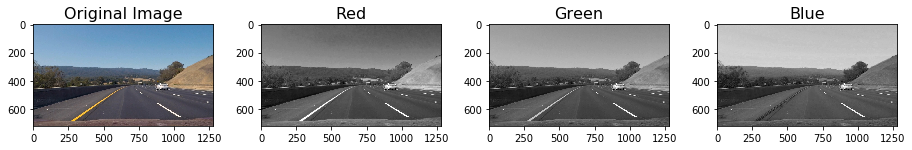

In [320]:
# Color Threshold

#RGB
#HLS
#HSV

# when we convert to grayscale we lose information regarding colour, e.g. yellow line
# RGB doesnt work well in varying light conditions




r_channel = image[:, :, 0]
g_channel = image[:, :, 1]
b_channel = image[:, :, 2]


# Show comparison between orignal and RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(r_channel, cmap="gray")
ax2.set_title("Red", fontsize=16)
ax3.imshow(g_channel, cmap="gray")
ax3.set_title("Green", fontsize=16)
ax4.imshow(b_channel, cmap="gray")
ax4.set_title("Blue", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)


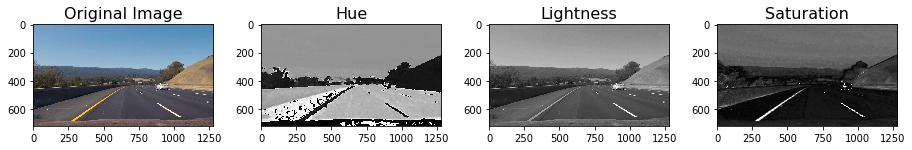

In [321]:

# HLS


hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

h_channel = hls_image[:, :, 0]
l_channel = hls_image[:, :, 1]
s_channel = hls_image[:, :, 2]



# Show comparison between orignal and HLS channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(h_channel, cmap="gray")
ax2.set_title("Hue", fontsize=16)
ax3.imshow(l_channel, cmap="gray")
ax3.set_title("Lightness", fontsize=16)
ax4.imshow(s_channel, cmap="gray")
ax4.set_title("Saturation", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)


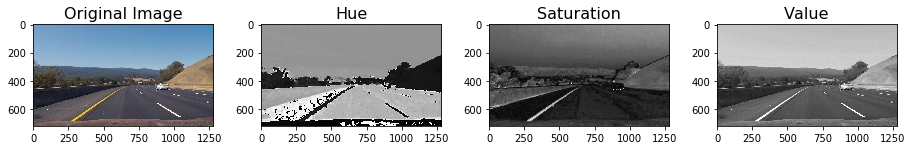

In [322]:
# HSV

hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

h_channel = hsv_image[:, :, 0]
s_channel = hsv_image[:, :, 1]
v_channel = hsv_image[:, :, 2]



# Show comparison between orignal and HSV channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(h_channel, cmap="gray")
ax2.set_title("Hue", fontsize=16)
ax3.imshow(s_channel, cmap="gray")
ax3.set_title("Saturation", fontsize=16)
ax4.imshow(v_channel, cmap="gray")
ax4.set_title("Value", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)


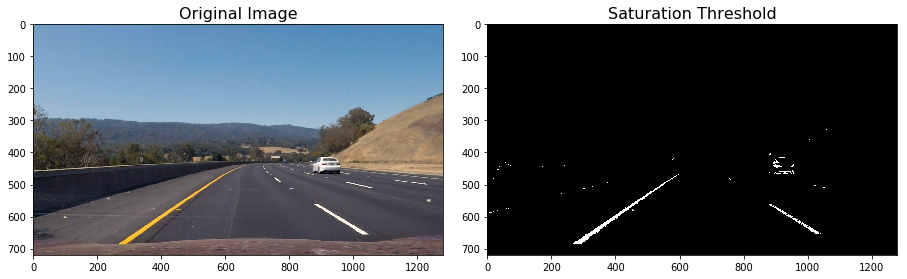

In [323]:
# Conclusion: S channel of HLS gives best outcome
# Could also combined different thresholds

def saturation_threshold(image, thresh=(0, 255)):
    
    """
    Input: RGB Image
    
    Output: Binary image filtered on saturation 
    
    """
    
    
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    s_channel = hls_image[:, :, 2]
    
    binary = np.zeros_like(s_channel)
    binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary



sat_binary = saturation_threshold(image, thresh=(150, 255))

# Show comparison between orignal and Saturation Threshold channels
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize=16)
ax2.imshow(sat_binary, cmap="gray")
ax2.set_title("Saturation Threshold", fontsize=16)
plt.subplots_adjust(left=0.0, right=1, top=0.9, bottom=0.0)



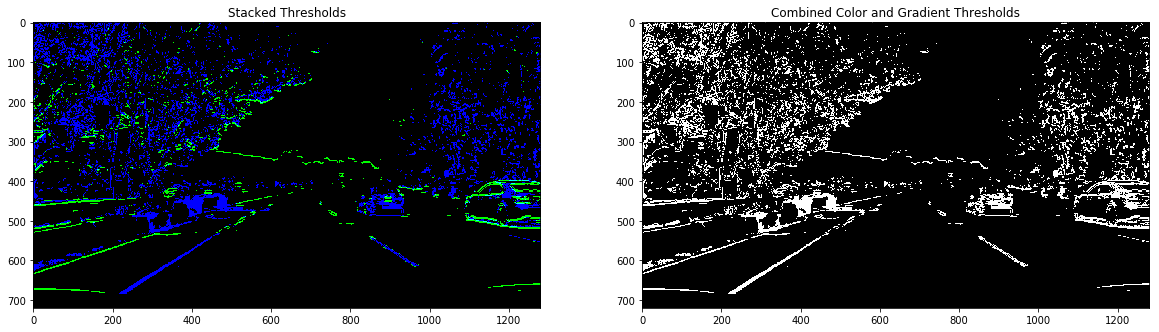

In [406]:
# Color and Gradient Thresholds


def combined_color_threshold(image):
    
    combined_binary = combined_threshold(image, kernel_size=15)
    
    sat_binary = saturation_threshold(image, thresh=(180, 255))
    
    color_binary = np.dstack((np.zeros_like(combined_binary), combined_binary, sat_binary)) 


    # Combine the two binary thresholds
    combined_color_binary = np.zeros_like(combined_binary)
    combined_color_binary[(combined_binary == 1) | (sat_binary == 1)] = 1
    
    return combined_color_binary, color_binary


# Stack each channel to view their individual contributions in green and  blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors

#color_binary = np.dstack((np.zeros_like(combined_binary), combined_binary, sat_binary)) 


# Combine the two binary thresholds
#combined_color_binary = np.zeros_like(combined_binary)
#combined_color_binary[(combined_binary == 1) | (sat_binary == 1)] = 1


combined_color_binary, color_binary = combined_color_threshold(image)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title("Stacked Thresholds")
ax1.imshow(color_binary)

ax2.set_title("Combined Color and Gradient Thresholds")
ax2.imshow(combined_color_binary, cmap="gray")

In [218]:
# compute perspective transforms

def compute_transform_matrices(src, dst):
    
    """TODO"""
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, Minv)

# do perspective transform


def perspective_transform(img, src, dst):
    
    
    M, Minv = compute_transform_matrices(src, dst)
    
    img_size = (img.shape[1], img.shape[0])
    
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped


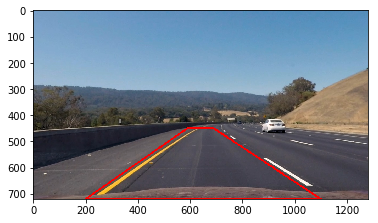

In [352]:
# Perspective Transform


transform_image = mpimg.imread("test_images/test3.jpg")

undist_image = undistort_image(transform_image, mtx, dist)

transform_copy = np.copy(undist_image)

bot_px = transform_copy.shape[0] 


src_points = np.array([[200, bot_px], [590, 450], [690, 450], [1100, bot_px]], np.int32)

cv2.polylines(transform_copy, [src_points], True, (255, 0, 0), 5)

plt.imshow(transform_copy)

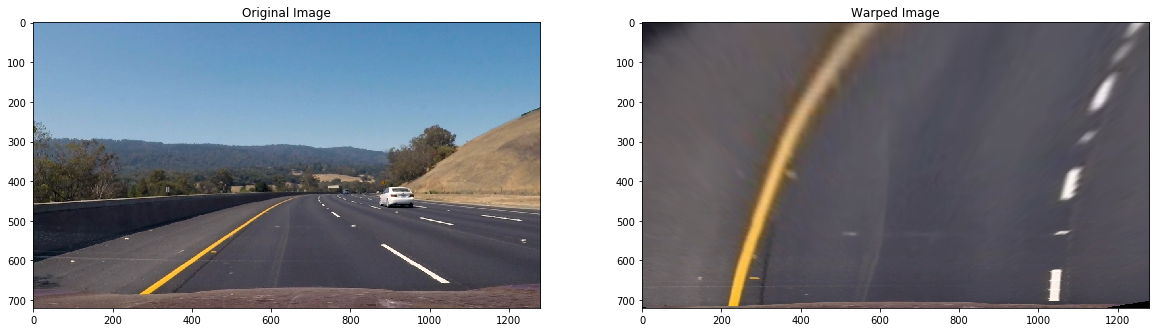

In [353]:


# NEED TO UNDISTORT IMAGE


src = np.float32(src_points)
dst = np.float32([[200, bot_px], [200, 0], [1000, 0], [1000, bot_px]])


perspective_transformed_img = perspective_transform(undist_image, src, dst)

#cv2.polylines(perspective_transformed_img, [dst.astype(np.int32)], True, (255, 0, 0), 5)



# Plotting Perspective Transformed Images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title("Original Image")
ax1.imshow(transform_image)

ax2.set_title("Warped Image")
ax2.imshow(perspective_transformed_img)


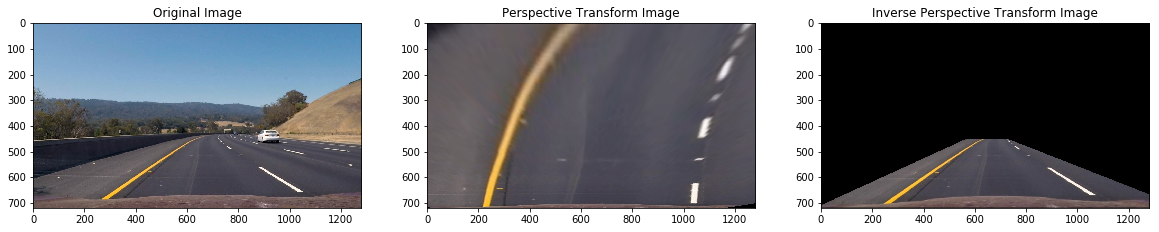

In [354]:

# Inverse Perspective Transform
inverse_image = perspective_transform(perspective_transformed_img, dst, src)


# Plotting Perspective Transformed Images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.set_title("Original Image")
ax1.imshow(transform_image)

ax2.set_title("Perspective Transform Image")
ax2.imshow(perspective_transformed_img)

ax3.set_title("Inverse Perspective Transform Image")
ax3.imshow(inverse_image)


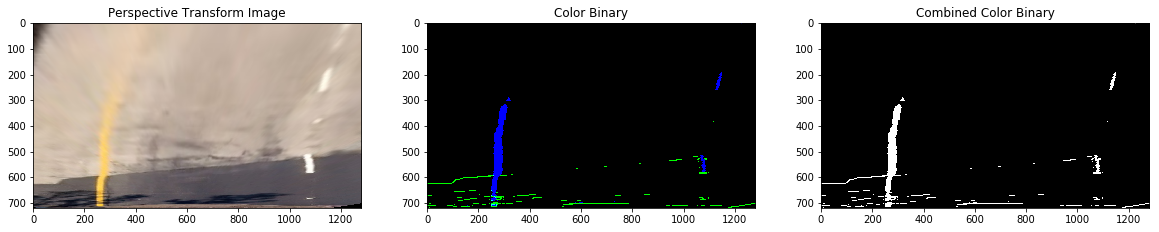

In [411]:


image = mpimg.imread("test_images/test4.jpg")

undist_image = undistort_image(image, mtx, dist)

perspective_transformed_img = perspective_transform(undist_image, src, dst)

combined_color_binary, color_binary = combined_color_threshold(perspective_transformed_img)


# Plotting Perspective Transformed Images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.set_title("Perspective Transform Image")
ax1.imshow(perspective_transformed_img)

ax2.set_title("Color Binary")
ax2.imshow(color_binary)

ax3.set_title("Combined Color Binary")
ax3.imshow(combined_color_binary, cmap="gray")



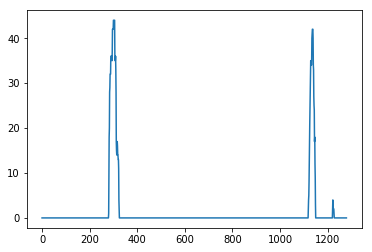

In [412]:

# Realised that the thresholds should be used on the perspective transformed images, not base ones.
# Less noise closer up
# need to redo the thresholds


# TODO:
# Need to Add a colour filter, so can have lower sat values, but only on yellow or whiete hue

histogram = np.sum(combined_color_binary[:combined_color_binary.shape[0] // 2, :], axis=0)

plt.plot(histogram)

In [ ]:
# Pipeline



In [413]:


binary_warped = combined_color_binary

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

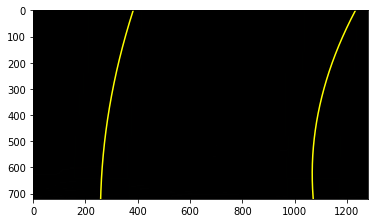

In [414]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [ ]:
# Detect Lane Lines



In [ ]:
# Determine Lane Curvature

